In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import ModelCheckpoint
from sklearn.model_selection
import cv2
import h5py

In [2]:
with h5py.File("data/processed_data.h5", "r") as f:
    imgs_train, labels_train = np.array(f["X_train"]), np.array(f["y_train"])
    imgs_test, labels_test = np.array(f["X_test"]), np.array(f["y_test"])

imgs_train2 = []
for img in imgs_train:
    new_img = cv2.resize(img, (128,128))
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    imgs_train2.append(new_img)
for img in imgs_test:
    new_img = cv2.resize(img, (128,128))
    new_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
    imgs_train2.append(new_img)
imgs_train = np.array(imgs_train2)[:, :, :, np.newaxis] / 255
labels_train = np.vstack((labels_train,labels_test))

In [3]:
shape_img = imgs_train.shape[1:]
n_cat = labels_train.shape[1]
latent_dim = 256

In [4]:
class Sampling(Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def conv_block(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    activation = LeakyReLU(0.3),
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x

def conv_block_transpose(
    x,
    filters,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    activation = LeakyReLU(0.3),
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.3,
):
    x = Conv2DTranspose(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x

In [5]:
enc_input_image = Input(shape=(shape_img), name="input_image")
enc_input_label = Input(shape=(n_cat), name="input_label")

# convolutionals block
enc_conv = conv_block(enc_input_image, filters=64, use_bn=True) # 128x128x64
enc_conv = conv_block(enc_conv, filters=64, strides=(2,2), use_dropout=True) # 64x64x64

enc_conv = conv_block(enc_conv, filters=128) # 64x64x128
enc_conv = conv_block(enc_conv, filters=128, strides=(2,2), use_bn=True, use_dropout=True) # 32x32x128

enc_conv = conv_block(enc_conv, filters=256) # 32x32x256
enc_conv = conv_block(enc_conv, filters=256, use_dropout=True) # 32x32x256
enc_conv = conv_block(enc_conv, filters=256) # 32x32x256
enc_conv = conv_block(enc_conv, filters=256, strides=(2,2), use_bn=True, use_dropout=True) # 16x16x256

enc_conv = conv_block(enc_conv, filters=512, use_bn=True) # 16x16x512
enc_conv = conv_block(enc_conv, filters=512, use_dropout=True) # 16x16x512
enc_conv = conv_block(enc_conv, filters=512) # 16x16x512
enc_conv = conv_block(enc_conv, filters=512, strides=(2,2), use_bn=True, use_dropout=True) # 8x8x512

enc_conv = conv_block(enc_conv, filters=512) # 8x8x512
enc_conv = conv_block(enc_conv, filters=512, use_dropout=True) # 8x8x512
enc_conv = conv_block(enc_conv, filters=512) # 8x8x512
enc_conv = conv_block(enc_conv, filters=512, strides=(2,2), use_bn=True, use_dropout=True) # 4x4x512


# concat
flattened = Flatten()(enc_conv)
enc_concat = Concatenate()([flattened, enc_input_label])


enc_hidden = Dense(4096)(enc_concat)
enc_hidden = Dropout(0.3)(enc_hidden)
enc_hidden = Dense(2048)(enc_hidden)
enc_hidden = Dropout(0.3)(enc_hidden)
enc_hidden = Dense(1024)(enc_hidden)
z_mean = Dense(latent_dim, activation='linear', name="mu")(enc_hidden)
z_log_var = Dense(latent_dim, activation='linear', name="l_sigma")(enc_hidden)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model([enc_input_image, enc_input_label], [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         640       ['input_image[0][0]']         
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 leaky_re_lu (LeakyReLU)     multiple                     0         ['batch_normalization[0]

2023-07-26 00:46:33.227755: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 00:46:33.230441: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-26 00:46:33.230534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

 conv2d_14 (Conv2D)          (None, 8, 8, 512)            2359808   ['dropout_6[0][0]']           
                                                                                                  
 conv2d_15 (Conv2D)          (None, 4, 4, 512)            2359808   ['leaky_re_lu[14][0]']        
                                                                                                  
 batch_normalization_5 (Bat  (None, 4, 4, 512)            2048      ['conv2d_15[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 dropout_7 (Dropout)         (None, 4, 4, 512)            0         ['leaky_re_lu[15][0]']        
                                                                                                  
 flatten (Flatten)           (None, 8192)                 0         ['dropout_7[0][0]']           
          

In [6]:
dec_inp_latent_vector = Input(shape=(latent_dim), name="input_latent_vector")
decoder_inp_label = Input(shape=(n_cat), name = "input_label")
dec_concat = Concatenate(name="decoder_concat")([dec_inp_latent_vector, decoder_inp_label])

dec_hidden = Dense(1024, activation="relu")(dec_concat)
dec_hidden = Dropout(0.3)(dec_hidden)
dec_hidden = Dense(2048, activation="relu")(dec_hidden)
dec_hidden = Dropout(0.3)(dec_hidden)
dec_hidden = Dense(4096, activation="relu")(dec_hidden)
dec_hidden = Dense(4*4*512, activation="relu", name="hidden_layer7")(dec_hidden)
dec_hidden = Dropout(0.3)(dec_hidden)
reshaped = Reshape(target_shape=(4,4,512))(dec_hidden)

dec_conv = conv_block_transpose(reshaped, filters=512, use_bn=True, use_dropout=True)  # 4x4x512
dec_conv = conv_block_transpose(dec_conv, filters=512)  # 4x4x512
dec_conv = conv_block_transpose(dec_conv, filters=512, use_dropout=True)  # 4x4x512
dec_conv = conv_block_transpose(dec_conv, filters=512, strides=(2,2), use_bn=True)  # 8x8x512

dec_conv = conv_block_transpose(dec_conv, filters=512, use_bn=True)  # 8x8x512
dec_conv = conv_block_transpose(dec_conv, filters=512, use_bn=True, use_dropout=True)  # 8x8x512
dec_conv = conv_block_transpose(dec_conv, filters=512, use_bn=True)  # 8x8x512
dec_conv = conv_block_transpose(dec_conv, filters=512, strides=(2,2), use_bn=True, use_dropout=True)  # 16x16x512

dec_conv = conv_block_transpose(dec_conv, filters=256, use_bn=True)  # 16x16x256
dec_conv = conv_block_transpose(dec_conv, filters=256, use_bn=True, use_dropout=True)  # 16x16x256
dec_conv = conv_block_transpose(dec_conv, filters=256, use_bn=True)  # 16x16x256
dec_conv = conv_block_transpose(dec_conv, filters=256, strides=(2,2), use_bn=True, use_dropout=True)  # 32x32x256

dec_conv = conv_block_transpose(dec_conv, filters=128, use_bn=True, use_dropout=True)  # 32x32x128
dec_conv = conv_block_transpose(dec_conv, filters=128, strides=(2,2), use_bn=True)  # 64x64x128

dec_conv = conv_block_transpose(dec_conv, filters=64, use_bn=True, use_dropout=True)  # 64x64x64
dec_conv = conv_block_transpose(dec_conv, filters=128, strides=(2,2), use_bn=True)  # 128x128x64

dec_output_img = Conv2DTranspose(filters=1, kernel_size=3, padding="same", activation="sigmoid")(dec_conv)


decoder = keras.Model([dec_inp_latent_vector, decoder_inp_label], dec_output_img, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_latent_vector (Input  [(None, 256)]                0         []                            
 Layer)                                                                                           
                                                                                                  
 input_label (InputLayer)    [(None, 4)]                  0         []                            
                                                                                                  
 decoder_concat (Concatenat  (None, 260)                  0         ['input_latent_vector[0][0]', 
 e)                                                                  'input_label[0][0]']         
                                                                                            

                                                                                                  
 conv2d_transpose_5 (Conv2D  (None, 8, 8, 512)            2359808   ['leaky_re_lu_1[4][0]']       
 Transpose)                                                                                       
                                                                                                  
 batch_normalization_9 (Bat  (None, 8, 8, 512)            2048      ['conv2d_transpose_5[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 dropout_15 (Dropout)        (None, 8, 8, 512)            0         ['leaky_re_lu_1[5][0]']       
                                                                                                  
 conv2d_transpose_6 (Conv2D  (None, 8, 8, 512)            2359808   ['dropout_15[0][0]']          
 Transpose

Total params: 66760001 (254.67 MB)
Trainable params: 66750913 (254.63 MB)
Non-trainable params: 9088 (35.50 KB)
__________________________________________________________________________________________________


In [7]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        imgs, labels = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([imgs, labels])
            reconstruction = self.decoder([z, labels])
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(imgs, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(1e-4))

In [17]:
vae.fit([imgs_train, labels_train], epochs=400, batch_size=64)

Epoch 1/200
51/51 [==============================] - 8s 156ms/step - loss: 6035.7685 - reconstruction_loss: 6029.5923 - kl_loss: 29.7147
Epoch 2/200
51/51 [==============================] - 8s 156ms/step - loss: 6039.7246 - reconstruction_loss: 6028.5269 - kl_loss: 29.6860
Epoch 3/200
51/51 [==============================] - 8s 156ms/step - loss: 6010.3926 - reconstruction_loss: 6029.0723 - kl_loss: 29.5913
Epoch 4/200
51/51 [==============================] - 8s 158ms/step - loss: 6092.2007 - reconstruction_loss: 6022.7773 - kl_loss: 29.5880
Epoch 5/200
51/51 [==============================] - 8s 158ms/step - loss: 6051.7951 - reconstruction_loss: 6025.3086 - kl_loss: 29.4679
Epoch 6/200
51/51 [==============================] - 8s 158ms/step - loss: 6073.5943 - reconstruction_loss: 6027.8853 - kl_loss: 29.7922
Epoch 7/200
51/51 [==============================] - 8s 158ms/step - loss: 6023.8361 - reconstruction_loss: 6028.1411 - kl_loss: 29.4436
Epoch 8/200
51/51 [======================

51/51 [==============================] - 8s 159ms/step - loss: 5996.3122 - reconstruction_loss: 5968.4858 - kl_loss: 28.1926
Epoch 61/200
51/51 [==============================] - 8s 160ms/step - loss: 5983.8263 - reconstruction_loss: 5968.6875 - kl_loss: 27.8199
Epoch 62/200
51/51 [==============================] - 8s 159ms/step - loss: 6020.9848 - reconstruction_loss: 5963.0649 - kl_loss: 27.7941
Epoch 63/200
51/51 [==============================] - 8s 160ms/step - loss: 6014.1642 - reconstruction_loss: 5967.4126 - kl_loss: 27.7547
Epoch 64/200
51/51 [==============================] - 8s 162ms/step - loss: 6001.0239 - reconstruction_loss: 5970.7358 - kl_loss: 27.9481
Epoch 65/200
51/51 [==============================] - 8s 160ms/step - loss: 5993.9854 - reconstruction_loss: 5964.9019 - kl_loss: 27.9660
Epoch 66/200
51/51 [==============================] - 8s 160ms/step - loss: 6006.1083 - reconstruction_loss: 5970.8623 - kl_loss: 28.0222
Epoch 67/200
51/51 [===========================

51/51 [==============================] - 8s 161ms/step - loss: 5943.8902 - reconstruction_loss: 5936.8086 - kl_loss: 26.3119
Epoch 120/200
51/51 [==============================] - 8s 162ms/step - loss: 5918.7338 - reconstruction_loss: 5932.6763 - kl_loss: 26.3175
Epoch 121/200
51/51 [==============================] - 8s 161ms/step - loss: 5962.0060 - reconstruction_loss: 5944.1157 - kl_loss: 26.5299
Epoch 122/200
51/51 [==============================] - 8s 162ms/step - loss: 6022.7214 - reconstruction_loss: 5933.8271 - kl_loss: 26.3316
Epoch 123/200
51/51 [==============================] - 8s 160ms/step - loss: 5993.1668 - reconstruction_loss: 5929.5654 - kl_loss: 26.2912
Epoch 124/200
51/51 [==============================] - 8s 160ms/step - loss: 5945.5672 - reconstruction_loss: 5927.4297 - kl_loss: 26.2349
Epoch 125/200
51/51 [==============================] - 8s 160ms/step - loss: 5946.0816 - reconstruction_loss: 5922.8501 - kl_loss: 26.0753
Epoch 126/200
51/51 [====================

51/51 [==============================] - 8s 161ms/step - loss: 5937.7746 - reconstruction_loss: 5907.5864 - kl_loss: 25.2181
Epoch 179/200
51/51 [==============================] - 8s 161ms/step - loss: 5907.8500 - reconstruction_loss: 5907.1611 - kl_loss: 25.4388
Epoch 180/200
51/51 [==============================] - 8s 161ms/step - loss: 5916.0637 - reconstruction_loss: 5908.6245 - kl_loss: 25.1389
Epoch 181/200
51/51 [==============================] - 8s 161ms/step - loss: 5964.2132 - reconstruction_loss: 5906.2402 - kl_loss: 25.0832
Epoch 182/200
51/51 [==============================] - 8s 161ms/step - loss: 5915.6944 - reconstruction_loss: 5909.7480 - kl_loss: 25.3214
Epoch 183/200
51/51 [==============================] - 8s 161ms/step - loss: 5937.0095 - reconstruction_loss: 5907.2891 - kl_loss: 25.2789
Epoch 184/200
51/51 [==============================] - 8s 160ms/step - loss: 5927.3875 - reconstruction_loss: 5904.0669 - kl_loss: 24.9339
Epoch 185/200
51/51 [====================

In [ ]:
_, _, z = vae.encoder.predict([imgs_train[10:11], labels_train[10:11]])

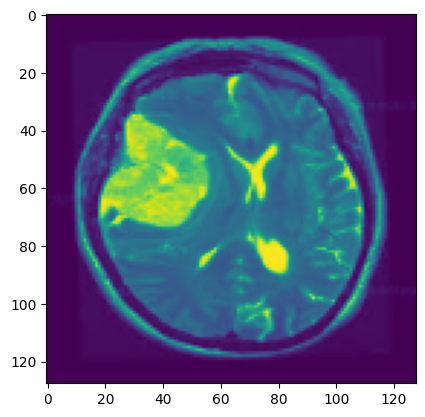

In [26]:
plt.imshow(imgs_train[10])

1/1 [==============================] - 0s 11ms/step


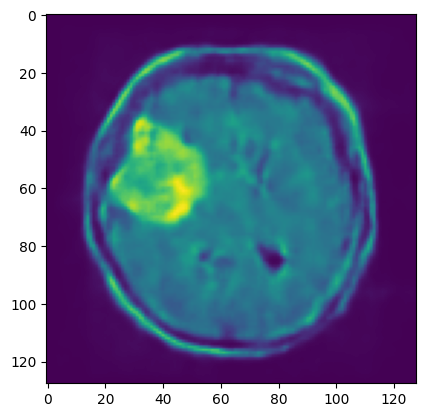

In [32]:
import matplotlib.pyplot as plt
plt.imshow(vae.decoder.predict([z, labels_train[10:11]]).reshape(128,128))

1/1 [==============================] - 0s 15ms/step


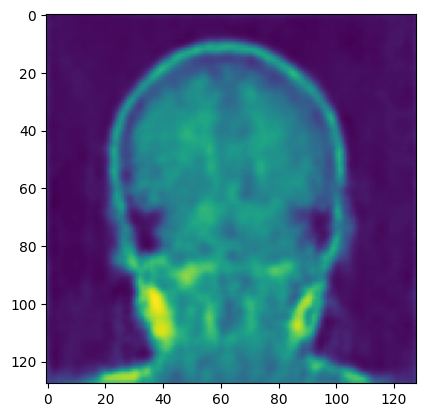

In [15]:
import matplotlib.pyplot as plt
plt.imshow(vae.decoder.predict([z, labels_train[2:3]]).reshape(128,128))

In [ ]:
z.min()

In [31]:
z = z + np.random.uniform(-1.25, 1.25, size=(z.shape))

In [ ]:
z.max()

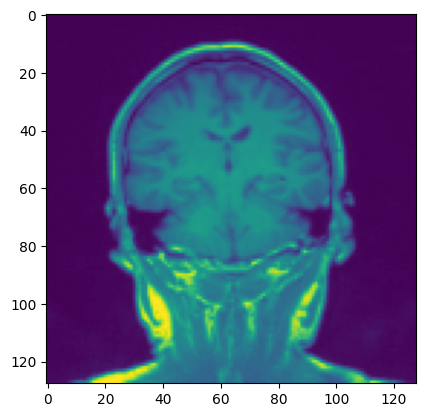

In [16]:
plt.imshow(imgs_train[2])